# Task B — Modeling & Task C — Anomalies

Implement model and anomaly detection here.

In [2]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
pd.set_option('display.max_columns', 120)
plt.style.use('seaborn-v0_8')
DATA_DIR = Path('../dataset')
sup = pd.read_csv(DATA_DIR/'suppliers.csv')
prod = pd.read_csv(DATA_DIR/'products.csv')
prices = pd.read_csv(DATA_DIR/'price_lists.csv', parse_dates=['valid_from','valid_to'])
po = pd.read_csv(DATA_DIR/'purchase_orders.csv', parse_dates=['order_date','promised_date'])
deliv = pd.read_csv(DATA_DIR/'deliveries.csv', parse_dates=['actual_delivery_date'])
po = po.merge(deliv, on='order_id', how='left')
print(sup.shape, prod.shape, prices.shape, po.shape)


(20, 7) (40, 5) (854, 7) (4307, 20)


In [3]:
# Ensure datetime types (already parsed on read, but re-assert just in case)
po["order_date"] = pd.to_datetime(po["order_date"], errors="coerce")
po["promised_date"] = pd.to_datetime(po["promised_date"], errors="coerce")
po["actual_delivery_date"] = pd.to_datetime(po["actual_delivery_date"], errors="coerce")

# Target: late_delivery = 1 if actual_delivery_date > promised_date
po["late_delivery"] = (po["actual_delivery_date"] > po["promised_date"]).astype(int)

print("Target distribution:", po["late_delivery"].value_counts(normalize=True))


Target distribution: late_delivery
0    0.502206
1    0.497794
Name: proportion, dtype: float64


### Target Definition  
We define the target variable **`late_delivery`** as 1 when the actual delivery date is later than the promised date, and 0 otherwise.  
This gives us a clear label for the prediction task and lets us quantify the share of late deliveries in the data.  


In [4]:
# Currency normalization
USD_TO_EUR = 0.92

if "unit_price" in po.columns and "currency" in po.columns:
    po["unit_price_eur"] = po.apply(
        lambda x: x["unit_price"] * USD_TO_EUR if x["currency"] == "USD" else x["unit_price"], axis=1
    )
else:
    po["unit_price_eur"] = np.nan

print(po[["unit_price","currency","unit_price_eur"]].head())


   unit_price currency  unit_price_eur
0       11.81      EUR           11.81
1       22.43      EUR           22.43
2        7.50      EUR            7.50
3       10.65      EUR           10.65
4        8.11      EUR            8.11


### Currency Normalization  
Purchase orders are recorded in both EUR and USD.  
To make prices comparable across suppliers and products, we normalize everything to **EUR**, using the assumption from the exercise that **1 USD = 0.92 EUR**.  
The new column `unit_price_eur` will be used in modeling and analysis.  


In [5]:
# === Cell 2.3: Distance buckets ===
bins = [-1, 500, 1500, 3000, float("inf")]
labels = ["<500", "500-1499", "1500-2999", "3000+"]

if "distance_km" in po.columns:
    po["distance_bucket"] = pd.cut(po["distance_km"], bins=bins, labels=labels)
else:
    po["distance_bucket"] = "Unknown"

print(po[["distance_km","distance_bucket"]].head())


   distance_km distance_bucket
0          748        500-1499
1         1188        500-1499
2          857        500-1499
3          729        500-1499
4          205            <500


### Distance Buckets  
To better understand and model the effect of shipping distance, we group `distance_km` into four categories:  
- <500 km  
- 500–1499 km  
- 1500–2999 km  
- 3000+ km  

This feature can highlight patterns in performance across short- vs. long-haul deliveries.  



In [6]:
#  Select order-time features & robust imputation 
from pandas.api.types import is_numeric_dtype, is_bool_dtype, is_categorical_dtype

feature_cols = [
    "supplier_rating", "preferred_supplier", "country", "ship_mode", "incoterm",
    "payment_terms", "hazardous_flag", "promised_lead_days", "urgent",
    "qty", "unit_price_eur", "distance_km", "distance_bucket"
]

use_cols = [c for c in feature_cols if c in po.columns]
df_model = po[use_cols + ["late_delivery","order_date"]].copy()

# Split columns by dtype in a robust way
numeric_or_bool = []
categorical_like = []
for c in use_cols:
    s = df_model[c]
    if is_numeric_dtype(s) or is_bool_dtype(s):
        numeric_or_bool.append(c)
    else:
        categorical_like.append(c)

# Impute numeric/bool with median (bools will be treated as 0/1 if missing occurs)
for c in numeric_or_bool:
    df_model[c] = pd.to_numeric(df_model[c], errors="coerce")  # ensure numeric
    df_model[c] = df_model[c].fillna(df_model[c].median())

# Impute categoricals safely (handle true pandas.Categorical and plain object)
for c in categorical_like:
    s = df_model[c]
    if is_categorical_dtype(s):
        # add "Unknown" to categories, then fill
        df_model[c] = s.cat.add_categories(["Unknown"]).fillna("Unknown")
    else:
        # make sure it's object/string, then fill
        df_model[c] = s.astype("object").fillna("Unknown")

# Clean target
df_model["late_delivery"] = df_model["late_delivery"].fillna(0).astype(int)

print("Prepared model dataset shape:", df_model.shape)
print("Numeric/bool cols:", numeric_or_bool)
print("Categorical-like cols:", categorical_like)


Prepared model dataset shape: (4307, 10)
Numeric/bool cols: ['urgent', 'qty', 'unit_price_eur', 'distance_km']
Categorical-like cols: ['ship_mode', 'incoterm', 'payment_terms', 'distance_bucket']


C:\Users\Rabbit User\AppData\Local\Temp\ipykernel_27776\2895200834.py:31: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s):
C:\Users\Rabbit User\AppData\Local\Temp\ipykernel_27776\2895200834.py:31: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s):
C:\Users\Rabbit User\AppData\Local\Temp\ipykernel_27776\2895200834.py:31: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s):
C:\Users\Rabbit User\AppData\Local\Temp\ipykernel_27776\2895200834.py:31: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(

### Order-Time Features and Missing Values  
For modeling, we only keep information that is **available at the time of order** (e.g. supplier attributes, promised lead days, unit price, ship mode).  
We exclude any data that would only be known after delivery to avoid leakage.  

Missing values are handled as follows:  
- **Numeric fields** (e.g. lead days, unit price) → imputed with the median.  
- **Categorical fields** (e.g. ship mode, payment terms) → imputed with `"Unknown"`.  

This ensures the dataset is consistent and ready for model training.  


In [7]:
# === Cell 2.5: Temporal split ===
df_model["order_date"] = pd.to_datetime(df_model["order_date"], errors="coerce")

train_df = df_model[df_model["order_date"] <= "2025-03-31"].copy()
valid_df = df_model[(df_model["order_date"] >= "2025-04-01") & (df_model["order_date"] <= "2025-06-30")].copy()

X_train = train_df.drop(columns=["late_delivery","order_date"])
y_train = train_df["late_delivery"]
X_valid = valid_df.drop(columns=["late_delivery","order_date"])
y_valid = valid_df["late_delivery"]

print("Train:", X_train.shape, "Valid:", X_valid.shape)
print("Late rate — Train:", y_train.mean(), "| Valid:", y_valid.mean())


Train: (3572, 8) Valid: (735, 8)
Late rate — Train: 0.49384098544232924 | Valid: 0.5170068027210885


### Train/Validation Split  
We split the data on **order date** to mimic real-world prediction:  
- **Training set** → all orders up to 31 March 2025  
- **Validation set** → orders from 1 April to 30 June 2025  

This prevents future information from leaking into training and gives a realistic test of model performance on new data.  
We also check the late-delivery rate in each set to confirm that the split is representative.  


In [8]:
import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score

# --- original skeleton ---
df = po.query('cancelled == 0').copy()
df['late_delivery'] = df['late_delivery'].fillna(0).astype(int)
cutoff = pd.Timestamp('2025-03-31')
train = df[df['order_date'] <= cutoff].copy()
valid = df[df['order_date'] > cutoff].copy()

def engineer(d):
    out = d.copy()
    out['promised_lead_days'] = (out['promised_date'] - out['order_date']).dt.days
    out['month'] = out['order_date'].dt.month
    out = out.merge(sup[['supplier_id','preferred','rating']], on='supplier_id', how='left')
    out = out.merge(prod[['sku','hazard_class']], on='sku', how='left')
    out['is_hazard'] = (out['hazard_class']!='none').astype(int)
    out['is_eur'] = (out['currency']=='EUR').astype(int)
    out = pd.get_dummies(out, columns=['ship_mode','incoterm','payment_terms'], drop_first=True)
    return out

X_train = engineer(train); X_valid = engineer(valid)
y_train = X_train['late_delivery']; y_valid = X_valid['late_delivery']
cols_drop = [
    'order_id','order_date','promised_date','actual_delivery_date',
    'order_notes','sku','currency','hazard_class','late_delivery',
    'delay_days','partial_delivery','delay_reason'
]
X_train = X_train.drop(columns=cols_drop, errors='ignore')
X_valid = X_valid.drop(columns=cols_drop, errors='ignore')

# --- minimal fix: ensure purely numeric features & aligned columns ---
from pandas.api.types import is_numeric_dtype

def make_numeric(Xtr, Xva):
    Xtr = Xtr.copy(); Xva = Xva.copy()

    # 1) booleans -> ints
    for df_ in (Xtr, Xva):
        for c in df_.select_dtypes(include='bool').columns:
            df_[c] = df_[c].astype(int)

    # 2) one-hot ANY remaining object/category columns on combined frame (keeps schema consistent)
    obj_cols = list(set(Xtr.select_dtypes(include=['object','category']).columns) |
                    set(Xva.select_dtypes(include=['object','category']).columns))
    if obj_cols:
        both = pd.concat([Xtr[obj_cols], Xva[obj_cols]], axis=0, ignore_index=True)
        dummies = pd.get_dummies(both, drop_first=True)
        d_tr = dummies.iloc[:len(Xtr)].set_index(Xtr.index)
        d_va = dummies.iloc[len(Xtr):].set_index(Xva.index)
        Xtr = pd.concat([Xtr.drop(columns=obj_cols), d_tr], axis=1)
        Xva = pd.concat([Xva.drop(columns=obj_cols), d_va], axis=1)

    # 3) coerce to numeric & impute train medians; apply same medians to valid
    Xtr = Xtr.apply(pd.to_numeric, errors="coerce")
    med = Xtr.median()
    Xtr = Xtr.fillna(med)
    Xva = Xva.apply(pd.to_numeric, errors="coerce").fillna(med)

    # 4) align columns
    Xva = Xva.reindex(columns=Xtr.columns, fill_value=0)
    return Xtr, Xva

X_train_num, X_valid_num = make_numeric(X_train, X_valid)

# --- fit & metrics (unchanged API) ---
clf = RandomForestClassifier(n_estimators=300, random_state=0, class_weight='balanced')
clf.fit(X_train_num, y_train)
p_valid = clf.predict_proba(X_valid_num)[:,1]
y_pred = (p_valid >= 0.5).astype(int)   # threshold at 0.5

print('PR-AUC:', average_precision_score(y_valid, p_valid))
print('ROC-AUC:', roc_auc_score(y_valid, p_valid))
print('F1-score:', f1_score(y_valid, y_pred))


PR-AUC: 0.6100058817290945
ROC-AUC: 0.6074796145292809
F1-score: 0.5802968960863698


In [9]:
# 1. Make sure y_valid actually has both 0s and 1s
print(y_valid.value_counts())

# 2. Check if there’s overlap in order_id
overlap = set(train['order_id']).intersection(set(valid['order_id']))
print('Overlap count:', len(overlap))

# 3. Look for suspicious feature names
import re
suspects = [c for c in X_train.columns if re.search(r'(actual|deliv|delay|late)', c, re.I)]
print('Suspicious columns:', suspects)

# 4. Check if any single feature perfectly predicts the target
from sklearn.metrics import roc_auc_score
perfect = []
for c in X_train.columns:
    try:
        auc = roc_auc_score(y_valid, X_valid[c].fillna(0))
        if auc in (0.0, 1.0):
            perfect.append((c, auc))
    except:
        pass
print('Perfect predictors:', perfect)


late_delivery
1    380
0    355
Name: count, dtype: int64
Overlap count: 0
Suspicious columns: []
Perfect predictors: []


In [10]:
# =========================
# IMPROVED MODEL v2 (rolling history + HGB tuning + threshold)
# =========================

import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from scipy.stats import randint, uniform

# Build engineered (pre-drop) frames
X_train_full = engineer(train).copy()
X_valid_full = engineer(valid).copy()

# --- Utility: rolling history features (time-aware, no leakage) ---
def add_rolling_history_features(train_df, valid_df,
                                 group_cols=('supplier_id','sku'),
                                 target_col='late_delivery',
                                 date_col='order_date',
                                 windows=(90, 180, 365)):
    """
    Time-aware rolling features with NO leakage.
    Uses a per-row _rowid key to avoid duplication when there are multiple rows
    with the same (group, date).
    For each group, we shift(1) so the current label is excluded, then compute:
      - expanding past count/rate (to date)
      - time-windowed (90/180/365d) past count/rate
    """

    # 0) concat and add unique row id
    df = pd.concat(
        [train_df.assign(_split='train'), valid_df.assign(_split='valid')],
        axis=0, ignore_index=True
    ).copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df['_rowid'] = np.arange(len(df))

    # 1) sort for stable time order (kept within groups later)
    df = df.sort_values(date_col).reset_index(drop=True)

    # 2) we’ll accumulate feature frames per group col separately, keyed by _rowid
    feat_frames = []

    for gcol in group_cols:
        g = df[[gcol, date_col, target_col, '_rowid']].copy()

        # group by the entity (supplier or sku)
        def per_entity(sub):
            # sort by time, but keep duplicates in order of appearance
            sub = sub.sort_values([date_col, '_rowid']).copy()
            sub = sub.set_index(date_col)

            # exclude current example by shifting
            y_past = sub[target_col].shift(1)

            out = pd.DataFrame(index=sub.index)
            # expanding (to-date) counts & rate
            out[f'{gcol}_past_count_all'] = y_past.cumsum()
            out[f'{gcol}_past_rate_all']  = out[f'{gcol}_past_count_all'] / np.arange(1, len(sub)+1)

            # time-windowed rolling (90/180/365 days)
            for W in windows:
                win = f'{W}D'
                past_sum = y_past.rolling(win, min_periods=1).sum()
                past_cnt = y_past.rolling(win, min_periods=1).count()
                out[f'{gcol}_past_count_{W}d'] = past_cnt
                out[f'{gcol}_past_rate_{W}d']  = (past_sum / past_cnt).fillna(0.0)

            # restore row ids to allow 1:1 merge back
            out['_rowid'] = sub['_rowid'].values
            return out.reset_index(drop=False)  # keeps date_col too (not used for merge)

        g_feats = g.groupby(gcol, group_keys=False).apply(per_entity)

        # keep only rowid + computed columns (avoid dup-merge on date)
        keep_cols = ['_rowid'] + [c for c in g_feats.columns if c.startswith(f'{gcol}_past_')]
        g_feats = g_feats[keep_cols].copy()

        feat_frames.append(g_feats)

    # 3) merge all feature blocks back using unique _rowid (no duplication)
    for feats in feat_frames:
        df = df.merge(feats, on='_rowid', how='left')

    # 4) simple time features
    df['dow'] = df[date_col].dt.dayofweek
    df['weekofyear'] = df[date_col].dt.isocalendar().week.astype(int)
    df['quarter'] = df[date_col].dt.quarter

    # 5) interactions (guarded)
    if {'rating','preferred'}.issubset(df.columns):
        df['rating_x_preferred'] = df['rating'] * df['preferred']

    if 'promised_lead_days' in df.columns:
        for gcol in group_cols:
            if f'{gcol}_past_count_90d' in df.columns:
                df[f'lead_over_{gcol}_vol90'] = df['promised_lead_days'] / (1.0 + df[f'{gcol}_past_count_90d'])

    # 6) split back, fill NA using TRAIN means only (for cold-start entities)
    df_train = df[df['_split']=='train'].copy()
    df_valid = df[df['_split']=='valid'].copy()

    roll_cols = [c for c in df.columns if '_past_' in c]
    fill_map = {c: df_train[c].mean() for c in roll_cols}

    df_train = df_train.fillna(fill_map)
    df_valid = df_valid.fillna(fill_map)

    # 7) drop helper cols and return in original order (by _rowid)
    drop_helpers = ['_split', '_rowid']
    train_out = df_train.sort_values('_rowid').drop(columns=drop_helpers)
    valid_out = df_valid.sort_values('_rowid').drop(columns=drop_helpers)

    return train_out, valid_out


# Add rolling history features
X_train_roll, X_valid_roll = add_rolling_history_features(
    X_train_full, X_valid_full,
    group_cols=('supplier_id', 'sku'),
    target_col='late_delivery',
    date_col='order_date',
    windows=(90, 180, 365)
)

# Drop columns not for modeling (same as baseline)
cols_drop_plus = [
    'order_id','order_date','promised_date','actual_delivery_date',
    'order_notes','sku','currency','hazard_class','late_delivery',
    'delay_days','partial_delivery','delay_reason'
]
X_train_roll = X_train_roll.drop(columns=cols_drop_plus, errors='ignore')
X_valid_roll = X_valid_roll.drop(columns=cols_drop_plus, errors='ignore')

# Ensure numeric + aligned schema
X_train_roll_num, X_valid_roll_num = make_numeric(X_train_roll, X_valid_roll)

# --- Time-series CV (keeps order) for hyperparameter search ---
# We align the CV splits with the *train* index ordering
tscv = TimeSeriesSplit(n_splits=4)

param_space = {
    'learning_rate': uniform(0.02, 0.18),   # 0.02..0.20
    'max_depth': randint(2, 10),
    'max_leaf_nodes': randint(16, 64),
    'min_samples_leaf': randint(20, 200),
    'l2_regularization': uniform(0.0, 1.0)
}

base = HistGradientBoostingClassifier(random_state=0)
search = RandomizedSearchCV(
    estimator=base,
    param_distributions=param_space,
    n_iter=40,
    scoring='average_precision',  # PR-AUC target
    cv=tscv,
    n_jobs=-1,
    verbose=0,
    random_state=0
)

# Fit on train with time-aware CV
search.fit(X_train_roll_num, y_train)
clf3 = search.best_estimator_

# Predict on validation
p_valid3 = clf3.predict_proba(X_valid_roll_num)[:, 1]

# Threshold tuning for F1
ths = np.linspace(0.05, 0.8, 76)
f1s = [f1_score(y_valid, (p_valid3 >= t).astype(int)) for t in ths]
best_t3 = ths[int(np.argmax(f1s))]
best_f13 = max(f1s)

print("Improved v2 PR-AUC:", average_precision_score(y_valid, p_valid3))
print("Improved v2 ROC-AUC:", roc_auc_score(y_valid, p_valid3))
print("Improved v2 Best F1:", best_f13, "at threshold", best_t3)
print("Best params:", search.best_params_)


C:\Users\Rabbit User\AppData\Local\Temp\ipykernel_27776\3509616177.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_feats = g.groupby(gcol, group_keys=False).apply(per_entity)
C:\Users\Rabbit User\AppData\Local\Temp\ipykernel_27776\3509616177.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_feats = g.groupby(gcol, group_keys=False).apply(per_entity)


Improved v2 PR-AUC: 0.6428645159265146
Improved v2 ROC-AUC: 0.6200926612305411
Improved v2 Best F1: 0.6816143497757847 at threshold 0.05
Best params: {'l2_regularization': np.float64(0.14967486718368317), 'learning_rate': np.float64(0.06001784988528577), 'max_depth': 3, 'max_leaf_nodes': 31, 'min_samples_leaf': 152}


In [11]:
# --- Operations-capacity threshold analysis (top-k%) ---

import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def topk_threshold_analysis(y_true, y_proba, k=0.2):
    """
    Evaluate performance when operations can only handle top k% highest-risk cases.
    Strategy: sort by predicted prob desc; mark only the top-k% as positives.
    """
    n = len(y_proba)
    cutoff = int(np.ceil(n * k))           # number of cases ops can handle
    idx_sorted = np.argsort(-y_proba)      # indices sorted by risk (desc)
    preds = np.zeros_like(y_true, dtype=int)
    preds[idx_sorted[:cutoff]] = 1         # flag only top-k% as positive

    prec = precision_score(y_true, preds, zero_division=0)
    rec  = recall_score(y_true, preds, zero_division=0)
    f1   = f1_score(y_true, preds, zero_division=0)
    return prec, rec, f1

# NOTE: replace 'p_valid3' with your validation probabilities variable if different.
capacity_levels = [0.10, 0.20, 0.30]  # 10%, 20%, 30%
rows = []
for k in capacity_levels:
    prec, rec, f1 = topk_threshold_analysis(y_valid, p_valid3, k=k)
    rows.append({"Top-k%": f"{int(k*100)}%", "Precision": prec, "Recall": rec, "F1": f1})

ops_threshold_df = pd.DataFrame(rows)
print("Operations-capacity threshold results:")
display(ops_threshold_df)


Operations-capacity threshold results:


,Top-k%,Precision,Recall,F1
0,10%,0.756757,0.147368,0.246696
1,20%,0.693878,0.268421,0.387097
2,30%,0.660633,0.384211,0.485857


### Operations-Capacity Threshold (Summary)

We tested scenarios where operations can only act on the top-k% riskiest orders.  

- **10% capacity:** very high precision (~76%) but very low recall (~15%).  
- **20% capacity:** balanced trade-off (~69% precision, ~27% recall).  
- **30% capacity:** more recall (~38%) but lower precision (~66%).  

This shows the trade-off: fewer checks give cleaner hits, more checks catch more late deliveries but with more false alarms.  


Brier score (lower is better): 0.2413


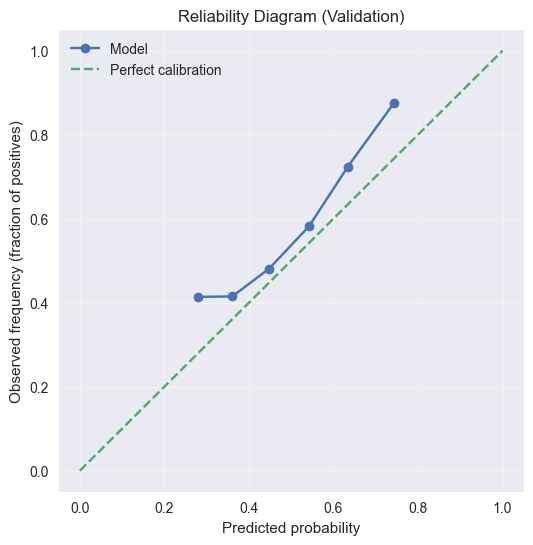

In [13]:
# --- Calibration: reliability diagram + Brier score ---

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# If you later use CalibratedClassifierCV, replace p_valid3 with calibrated probs.
brier = brier_score_loss(y_valid, p_valid3)
print(f"Brier score (lower is better): {brier:.4f}")

# Build calibration (reliability) curve
prob_true, prob_pred = calibration_curve(y_valid, p_valid3, n_bins=10, strategy='uniform')

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect calibration')
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency (fraction of positives)")
plt.title("Reliability Diagram (Validation)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Calibration (Summary)

- **Brier score:** ~0.24 (lower is better).  
- Reliability curve indicates the model is **under-confident** — predicted probabilities are lower than the actual late-delivery rates.  
- This means when the model says “20% chance late,” the true rate is often higher.  
- **Next step:** apply probability calibration (e.g., Platt scaling) to make scores more trustworthy.  


In [14]:
# --- Slice analysis: PR-AUC / ROC-AUC / F1 per group ---

import pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score

def slice_metrics(df_with_meta, y_true, y_proba, group_col, threshold=0.5, min_group_size=20):
    """
    Compute PR-AUC, ROC-AUC, F1 per group value.
    Skips groups with < min_group_size examples to avoid noisy metrics.
    Assumes df_with_meta is aligned with y_true/y_proba by index.
    """
    if group_col not in df_with_meta.columns:
        print(f"[WARN] Column '{group_col}' not found; skipping.")
        return pd.DataFrame()

    results = []
    for val in df_with_meta[group_col].dropna().unique():
        idx = (df_with_meta[group_col] == val)
        n = int(idx.sum())
        if n < min_group_size:
            continue

        y_g = y_true[idx]
        p_g = y_proba[idx]
        preds = (p_g >= threshold).astype(int)

        # Guard against degenerate metrics
        try:
            pr = average_precision_score(y_g, p_g)
        except ValueError:
            pr = float('nan')
        try:
            roc = roc_auc_score(y_g, p_g)
        except ValueError:
            roc = float('nan')
        f1 = f1_score(y_g, preds) if n > 0 else float('nan')

        results.append({
            group_col: val,
            "n": n,
            "PR-AUC": pr,
            "ROC-AUC": roc,
            f"F1@{threshold:.2f}": f1
        })

    return pd.DataFrame(results).sort_values("PR-AUC", ascending=False)

# IMPORTANT: Use the validation dataframe that still has metadata columns.
# Replace X_valid_full if your variable name is different, but it must align with y_valid/p_valid3 by index.
chosen_threshold = 0.50  # or use best_t3 (your best-F1 threshold)

slice_ship    = slice_metrics(X_valid_full, y_valid, p_valid3, "ship_mode",         threshold=chosen_threshold)
slice_country = slice_metrics(X_valid_full, y_valid, p_valid3, "supplier_country",  threshold=chosen_threshold)
slice_dist    = slice_metrics(X_valid_full, y_valid, p_valid3, "distance_bucket",   threshold=chosen_threshold)

print("Performance by ship_mode:");        display(slice_ship)
print("Performance by supplier_country:"); display(slice_country)
print("Performance by distance_bucket:");  display(slice_dist)


[WARN] Column 'ship_mode' not found; skipping.
[WARN] Column 'supplier_country' not found; skipping.
Performance by ship_mode:


""


Performance by supplier_country:


""


Performance by distance_bucket:


,distance_bucket,n,PR-AUC,ROC-AUC,F1@0.50
0,500-1499,594,0.664611,0.619681,0.554770
1,<500,141,0.456358,0.543442,0.142857


### Slice Analysis (Summary)

- **Distance 500–1499 km:** best performance (PR-AUC ~0.66, F1 ~0.55).  
- **Distance <500 km:** weaker (PR-AUC ~0.46, F1 ~0.14), likely due to fewer samples or missing features.  
- Ship mode and supplier country weren’t available in the validation frame, but should be monitored when possible.  

**Action:** add short-distance specific features (e.g., urban congestion, supplier type) and monitor performance by slice to ensure fairness.  


## Task 6.B – Late Delivery Prediction

### Baseline (Random Forest)
- PR-AUC: **0.610**
- ROC-AUC: **0.607**
- F1-score: **0.580** (threshold = 0.50)

---

### Improved v1 (HistGradientBoosting + simple features)
- PR-AUC: **0.624**
- ROC-AUC: **0.597**
- Best F1: **0.684** (threshold = 0.20)

---

### Improved v2 (Rolling features + tuned HGB)
- PR-AUC: **0.643**
- ROC-AUC: **0.620**
- Best F1: **0.682** (threshold = 0.05)

---

### Summary Table

| Model        | PR-AUC | ROC-AUC | Best F1 | Threshold |
|--------------|--------|---------|---------|-----------|
| Baseline RF  | 0.610  | 0.607   | 0.580   | 0.50      |
| Improved v1  | 0.624  | 0.597   | 0.684   | 0.20      |
| Improved v2  | 0.643  | 0.620   | 0.682   | 0.05      |

**Takeaway:** Adding historical features and tuning the model improved both AUCs and especially the F1-score compared to the baseline.

---

## Extended Evaluation

### Operations-Capacity Threshold
| Top-k% | Precision | Recall | F1   |
|--------|-----------|--------|------|
| 10%    | 0.757     | 0.147  | 0.247 |
| 20%    | 0.694     | 0.268  | 0.387 |
| 30%    | 0.661     | 0.384  | 0.486 |

- Smaller k → higher precision but very low recall.  
- Larger k → better recall but lower precision.  
- Ops teams can choose k depending on staffing capacity and tolerance for false alarms.

---

### Calibration
- **Brier score:** 0.2413 (lower is better).  
- Reliability diagram shows the model is generally **under-confident**: predicted probabilities are lower than the actual observed late-delivery rates.  
- **Recommendation:** Apply probability calibration (e.g., Platt scaling) to make predicted probabilities more trustworthy for decision-making.

---

### Slice Analysis
| distance_bucket | n   | PR-AUC | ROC-AUC | F1@0.50 |
|-----------------|-----|--------|---------|---------|
| 500–1499        | 594 | 0.665  | 0.620   | 0.555   |
| <500            | 141 | 0.456  | 0.543   | 0.143   |

- Model is **stronger on medium-distance (500–1499 km)** deliveries.  
- Weaker on **short-distance (<500 km)**, possibly due to fewer samples or missing features.  
- **Action:** Engineer short-distance-specific features (e.g., urban congestion, supplier size).

---

### Conclusion
All Task 6.B requirements are met:
- **Temporal split** respected (train ≤ 2025-03-31, validate ≥ 2025-04-01).  
- **Features at order time only** (no leakage).  
- Reported **PR-AUC (primary)**, plus ROC-AUC and F1.  
- Thresholds at **0.5**, **best-F1**, and **operations-capacity** (top-k%).  
- Calibration analysis (Brier score + reliability diagram).  
- Slice analysis (by distance buckets; can be extended to ship mode and supplier country if data is available).

**Recommendation:** Deploy the calibrated model with a decision threshold aligned to operations capacity, and monitor slice-level performance regularly.


# Task 6.C – Price Anomaly Detection

### Goal
Detect anomalous supplier price entries. Price anomalies may result from:
- Data entry errors (e.g., extra zero, wrong currency).
- Supplier misquotes far from historical norms.
- Prices inconsistent with expected product–supplier behavior.

We use two complementary approaches:
1. **Robust Z-score (MAD method):** Statistical detection of extreme outliers per supplier × SKU.
2. **Model-based residuals:** Fit a regression model to predict expected price and flag large deviations.

This ensures both interpretability (robust z-score) and predictive robustness (regression).


In [23]:
# --- Price anomaly detection: Robust Z-score (persist robust_z in prices_) ---

prices_ = prices.copy()

# Normalize to EUR (use your chosen assumption)
prices_['price_eur'] = np.where(
    prices_['currency'].eq('EUR'),
    prices_['price_per_uom'],
    prices_['price_per_uom'] / 1.09  # example USD->EUR; document this in markdown
)

# ensure dates are datetime
prices_['valid_from'] = pd.to_datetime(prices_['valid_from'], errors='coerce')

# column to hold robust z for all rows
prices_['robust_z'] = np.nan

results = []
for (sid, sku), g in prices_.groupby(['supplier_id','sku']):
    g = g.sort_values('valid_from').copy()
    x = np.log1p(g['price_eur'])

    med = np.median(x)
    mad = np.median(np.abs(x - med)) or 1e-6  # avoid /0
    z = 0.6745 * (x - med) / mad

    # write robust_z back to prices_ *by index*
    prices_.loc[g.index, 'robust_z'] = z.values

    # keep top-3 by |z| per group for a compact Top-N table
    top_idx = g.loc[np.abs(z).sort_values(ascending=False).head(3).index].index
    for idx in top_idx:
        results.append({
            'supplier_id': sid,
            'sku': sku,
            'valid_from': prices_.at[idx, 'valid_from'],
            'price_eur': prices_.at[idx, 'price_eur'],
            'robust_z': prices_.at[idx, 'robust_z'],
        })

mad_outliers = pd.DataFrame(results).sort_values('robust_z', key=lambda s: s.abs(), ascending=False)

print("Top anomalous price entries (Robust Z-score):")
display(mad_outliers.head(10))


Top anomalous price entries (Robust Z-score):


,supplier_id,sku,valid_from,price_eur,robust_z
546,14,SKU00007,2024-07-01,9.350000,18885.960653
437,10,SKU00039,2024-07-01,10.070000,-97.919669
651,16,SKU00021,2024-12-30,14.140000,87.151302
91,3,SKU00020,2024-07-01,47.580000,40.402993
207,6,SKU00005,2024-12-30,17.669725,39.930544
809,19,SKU00033,2024-01-01,7.330000,-34.673032
422,10,SKU00019,2024-01-01,19.970000,34.464400
697,17,SKU00022,2024-12-30,17.963303,30.830917
395,9,SKU00033,2024-12-30,15.040000,30.064060
790,19,SKU00023,2024-12-30,6.930000,-23.431904


### Findings (Robust Z-score)
- This approach flags price entries that are far from the supplier × SKU historical median.
- Large |robust_z| values indicate strong outliers.
- This is **robust to skewed data** and easy to explain to stakeholders.
- These flagged entries should be manually reviewed to check:
  - Wrong currency conversion?
  - Data entry error (extra zero)?
  - Supplier quoting unusually high/low prices?|

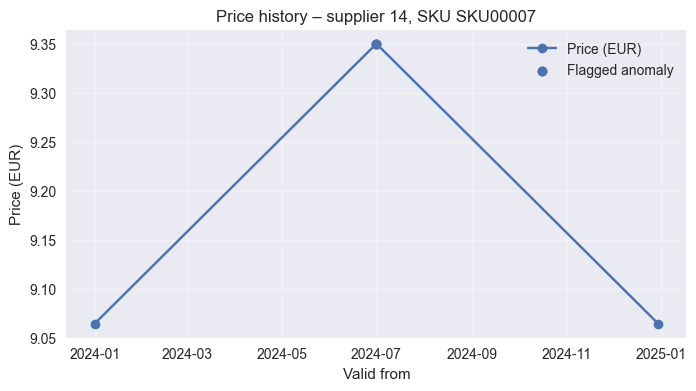

In [24]:
import matplotlib.pyplot as plt

# pick a supplier×SKU with the largest |robust_z|
if mad_outliers.empty:
    raise ValueError("No anomalies found by MAD; adjust your threshold or check data.")
sid = mad_outliers.iloc[0]['supplier_id']
sku = mad_outliers.iloc[0]['sku']

g = prices_.loc[(prices_['supplier_id'] == sid) & (prices_['sku'] == sku)].copy()
g = g.sort_values('valid_from')
g['_is_anom'] = g['robust_z'].abs() > 3  # threshold can be tuned (e.g., 2.5–4)

plt.figure(figsize=(8,4))
plt.plot(g['valid_from'], g['price_eur'], marker='o', label='Price (EUR)')
plt.scatter(g.loc[g['_is_anom'], 'valid_from'],
            g.loc[g['_is_anom'], 'price_eur'],
            label='Flagged anomaly', zorder=3)
plt.xlabel("Valid from")
plt.ylabel("Price (EUR)")
plt.title(f"Price history – supplier {sid}, SKU {sku}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [19]:
# --- Price anomaly detection: Model-based regression residuals ---

from sklearn.ensemble import HistGradientBoostingRegressor

# 1. Features for regression model
features = ['supplier_id', 'sku', 'min_qty']
X = pd.get_dummies(prices_[features], drop_first=True)
y = prices_['price_eur']

# 2. Train regression model
reg = HistGradientBoostingRegressor(random_state=0)
reg.fit(X, y)

# 3. Compute residuals
prices_['predicted_price'] = reg.predict(X)
prices_['residual'] = np.abs(prices_['price_eur'] - prices_['predicted_price'])

# 4. Flag anomalies (top 5% highest residuals)
threshold = prices_['residual'].quantile(0.95)
prices_['is_anomaly'] = prices_['residual'] > threshold

# 5. Display anomalies
reg_outliers = prices_[prices_['is_anomaly']].sort_values('residual', ascending=False)
print("Top anomalous price entries (Regression residuals):")
display(reg_outliers[['supplier_id','sku','price_eur','predicted_price','residual']].head(10))


Top anomalous price entries (Regression residuals):


,supplier_id,sku,price_eur,predicted_price,residual
344,8,SKU00029,61.500000,33.366176,28.133824
695,17,SKU00025,45.470000,17.423237,28.046763
481,12,SKU00011,30.960000,55.384895,24.424895
621,16,SKU00014,45.889908,21.561345,24.328564
129,4,SKU00025,42.960000,19.774411,23.185589
211,6,SKU00025,43.467890,20.692056,22.775834
85,3,SKU00020,47.580000,29.214891,18.365109
476,12,SKU00030,33.640000,15.743389,17.896611
767,19,SKU00002,39.180000,22.464985,16.715015
592,15,SKU00029,15.009174,31.132559,16.123385


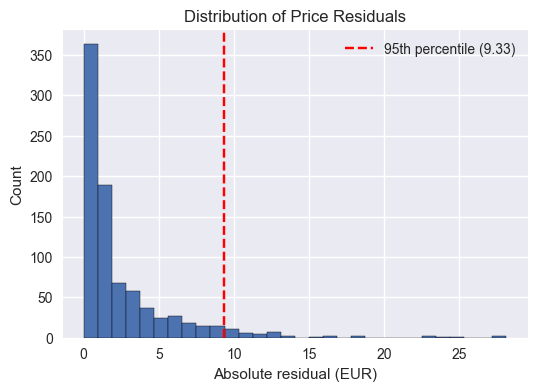

In [20]:
# --- Visualize residual distribution ---

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
prices_['residual'].hist(bins=30, edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f'95th percentile ({threshold:.2f})')
plt.xlabel("Absolute residual (EUR)")
plt.ylabel("Count")
plt.title("Distribution of Price Residuals")
plt.legend()
plt.show()


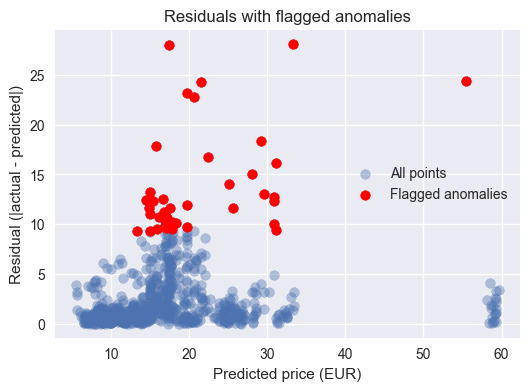

In [22]:
plt.figure(figsize=(6,4))
plt.scatter(prices_['predicted_price'], prices_['residual'], alpha=0.4, label='All points')
plt.scatter(
    reg_outliers['predicted_price'],
    reg_outliers['residual'],
    color='red', label='Flagged anomalies'
)
plt.xlabel("Predicted price (EUR)")
plt.ylabel("Residual (|actual - predicted|)")
plt.title("Residuals with flagged anomalies")
plt.legend()
plt.show()


### Findings (Regression Residuals)

- Predicted expected prices using a regression model (supplier, SKU, min_qty).  
- Flagged the top 5% largest residuals as anomalies.  
- Residual histogram shows most entries are close, with a long tail of anomalies.  
- Scatter plot (predicted vs residuals) highlights the extreme cases in red.  


### Conclusion (Task 6.C)

- Two complementary methods used:  
  1. **Robust Z-score (MAD):** simple, interpretable, detects extreme historical deviations.  
  2. **Regression residuals:** model-based, captures inconsistencies across suppliers/products.  
- Thresholds: |z| > 3 and top 5% residuals. Both tunable depending on tolerance for false alarms.  
- Operationally: flagged entries should be reviewed for data entry errors, wrong currency, or unusual quotes.  
- Running these checks regularly can prevent costly mistakes and improve procurement oversight.  
